<h1>Preprocessing for Audio Event Detection</h1>

In [2]:
import os
print(os.getcwd())

C:\Users\Harshit's PC


In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc,logfbank
import librosa

In [22]:
def plot_signals(signals):
    fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(10,10))
    fig.suptitle('Time series',size=20)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [23]:
def plot_fft(fft):
    fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(10,10))
    fig.suptitle('Fourier transforms',size=20)
    i=0
    for x in range(2):
        for y in range(5):
            data=list(fft.values())[i]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(data[0],data[1])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [24]:
def plot_fbank(fbank):
    fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(10,10))
    fig.suptitle('Filterbank coefficients',size=20)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [27]:
def plot_mfcc(mfcc):
    fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(20,20))
    fig.suptitle('Mel Filter Cepstral Coefficients',size=20)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfcc.keys())[i])
            axes[x,y].imshow(list(mfcc.values())[i],cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [20]:
def calc_fft(y,r):
    freq=np.fft.rfftfreq(len(y),d=1/r)
    amp=abs(np.fft.rfft(y)/len(y))
    return (freq,amp)

In [9]:
def envelope(y,r,threshold):
    mask=[]
    series=(pd.Series(y)).apply(np.abs)
    y_mean=series.rolling(window=int(r/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

<h2>Audio Compression and Feature Extraction</h2>

10
label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length(in sec), dtype: float64


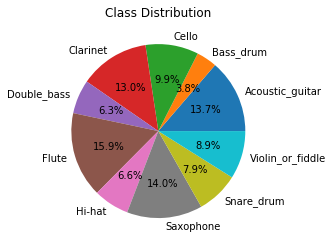

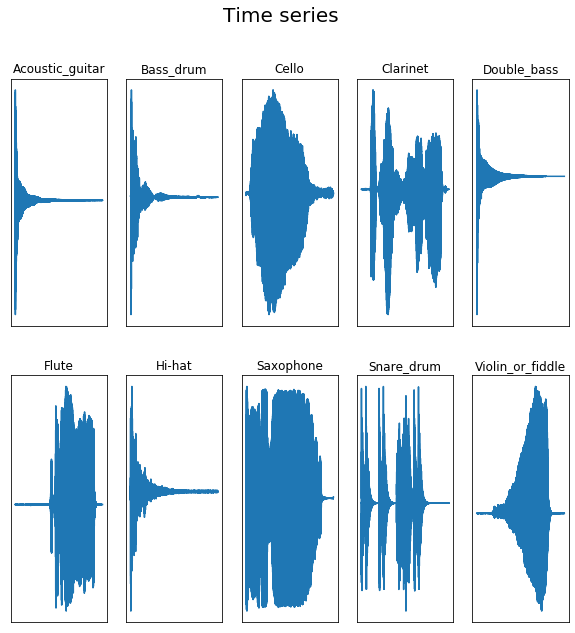

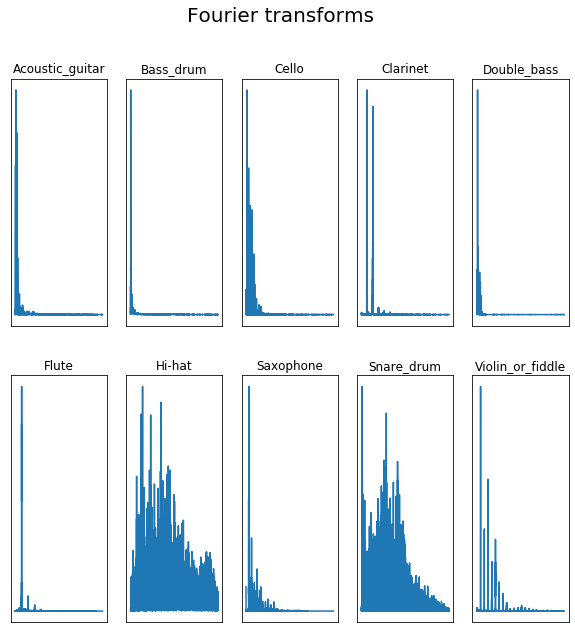

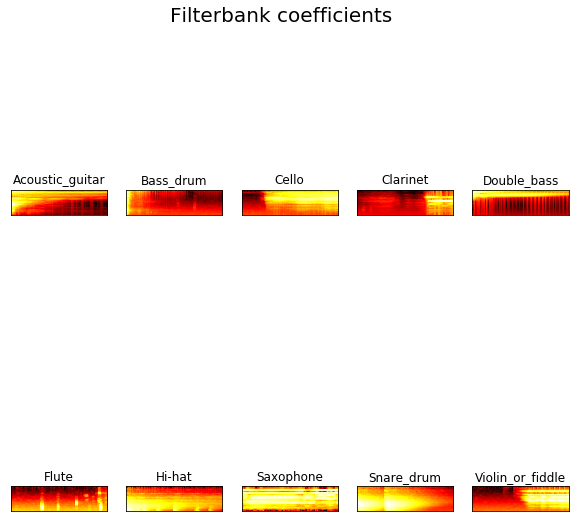

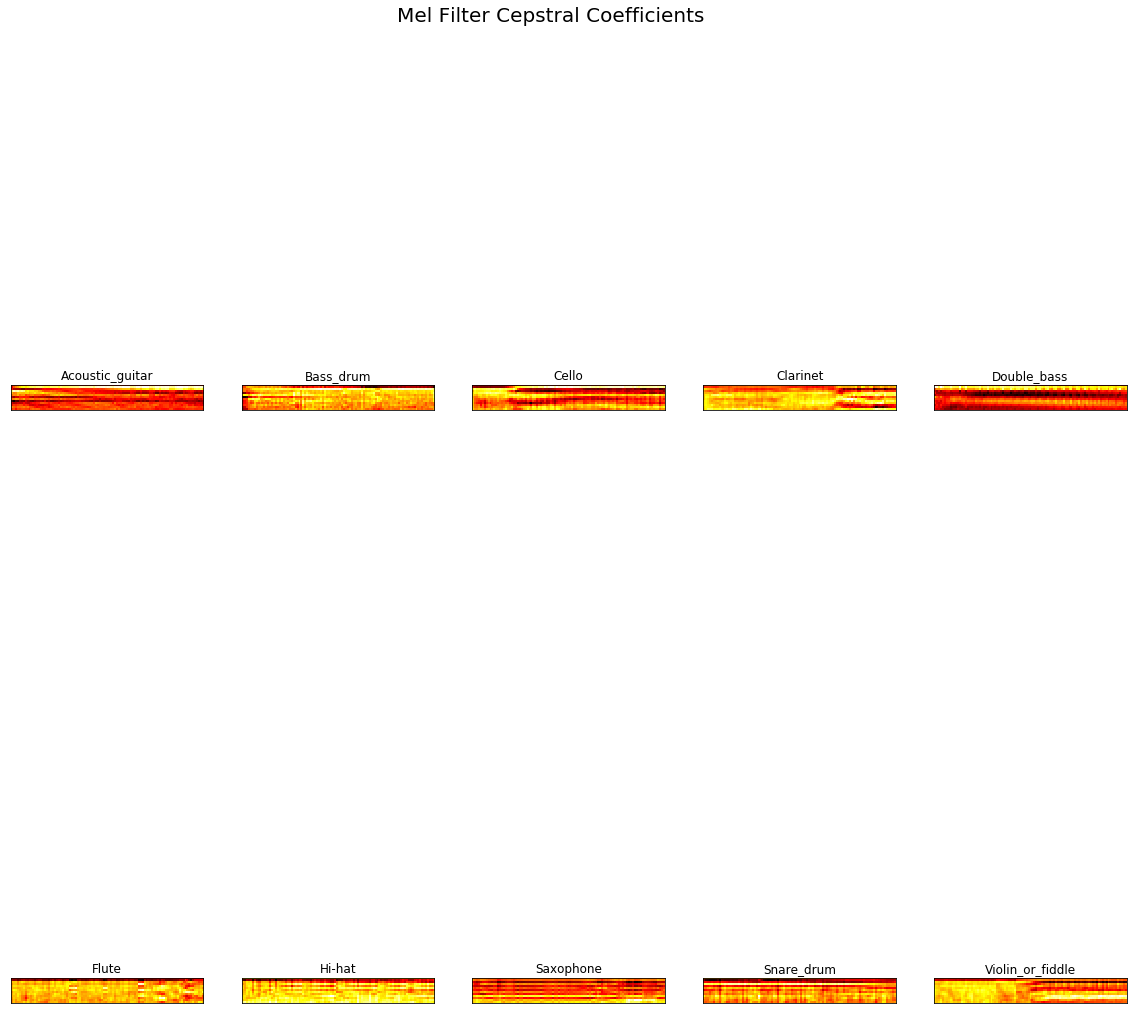

In [28]:
df=pd.read_csv('C:\Audio-Classification-master\instruments.csv')

#To visualize class DISTRIBUTION
df.set_index('fname',inplace=True)
for f in df.index:
    rate,signal=wavfile.read('C:\Audio-Classification-master\wavfiles/'+f)
    df.at[f,'length(in sec)']=signal.shape[0]/rate
    
classes=list(np.unique(df.label))
print(len(classes))
class_distribution=df.groupby(['label'])['length(in sec)'].mean()  #length(in sec) is the index of respective classes which gives the time length of the class
print(class_distribution)
fig,ax=plt.subplots()
ax.set_title('Class Distribution')
ax.pie(class_distribution,labels=class_distribution.index,shadow=False,autopct='%0.1f%%')
#ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

#To visualize the signal,its FFT,Mel filterbank energy and MFCC of just one sample of audio of each class
signal_dict={}
fft_dict={}
fbank_dict={}
mfcc_dict={}

for c in classes:
    wav_file=df[df.label==c].iloc[0,0]
    #print(df[df.label==c])
    length=df[df.label==c].iloc[0,2]
    signal,rate=librosa.load('C:\Audio-Classification-master\wavfiles/'+wav_file,sr=44100)
    signal_dict[c]=signal
    fft_dict[c]=calc_fft(signal,rate)
    
    bank=logfbank(signal[:rate],rate,nfft=1103).T
    #print('bank\n',bank)
    fbank_dict[c]=bank
    '''
    Signature:
logfbank(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
)
Docstring:
Compute log Mel-filterbank energy features from an audio signal.

:param signal: the audio signal from which to compute features. Should be an N*1 array
:param samplerate: the samplerate of the signal we are working with.
:param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
:param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
:param nfilt: the number of filters in the filterbank, default 26.
:param nfft: the FFT size. Default is 512.
:param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
:param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
:param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
:returns: A numpy array of size (NUMFRAMES(1000ms/winstep) by nfilt(26)) containing features. Each row holds 1 feature vector.
    '''
    mel=mfcc(signal[:rate],rate,nfft=1103).T
    mfcc_dict[c]=mel
    '''
    Signature:
mfcc(
    signal,
    samplerate=16000,
    winlen=0.025,
    winstep=0.01,
    numcep=13,
    nfilt=26,
    nfft=512,
    lowfreq=0,
    highfreq=None,
    preemph=0.97,
    ceplifter=22,
    appendEnergy=True,
    winfunc=<function <lambda> at 0x000001F4610D6D90>,
)
Docstring:
Compute MFCC features from an audio signal.

:param signal: the audio signal from which to compute features. Should be an N*1 array
:param samplerate: the samplerate of the signal we are working with.
:param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
:param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
:param numcep: the number of cepstrum to return, default 13
:param nfilt: the number of filters in the filterbank, default 26.
:param nfft: the FFT size. Default is 512.
:param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
:param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
:param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
:param ceplifter: apply a lifter to final cepstral coefficients. 0 is no lifter. Default is 22.
:param appendEnergy: if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy.
:param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
:returns: A numpy array of size (NUMFRAMES(1000ms/winstep) by numcep(13)) containing features. Each row holds 1 feature vector.
'''
    
plot_signals(signal_dict)
plt.show()

plot_fft(fft_dict)
plt.show()

plot_fbank(fbank_dict)
plt.show()

plot_mfcc(mfcc_dict)
plt.show()

<h2>Data Cleaning</h2>

mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 65)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 57)
mfcc (13, 99)
mfcc (13, 87)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 10)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 62)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 77)
mfcc (13, 99)
mfcc (13, 99)
mfcc (13, 22)
mfcc (13, 99)
mfcc (13, 99)


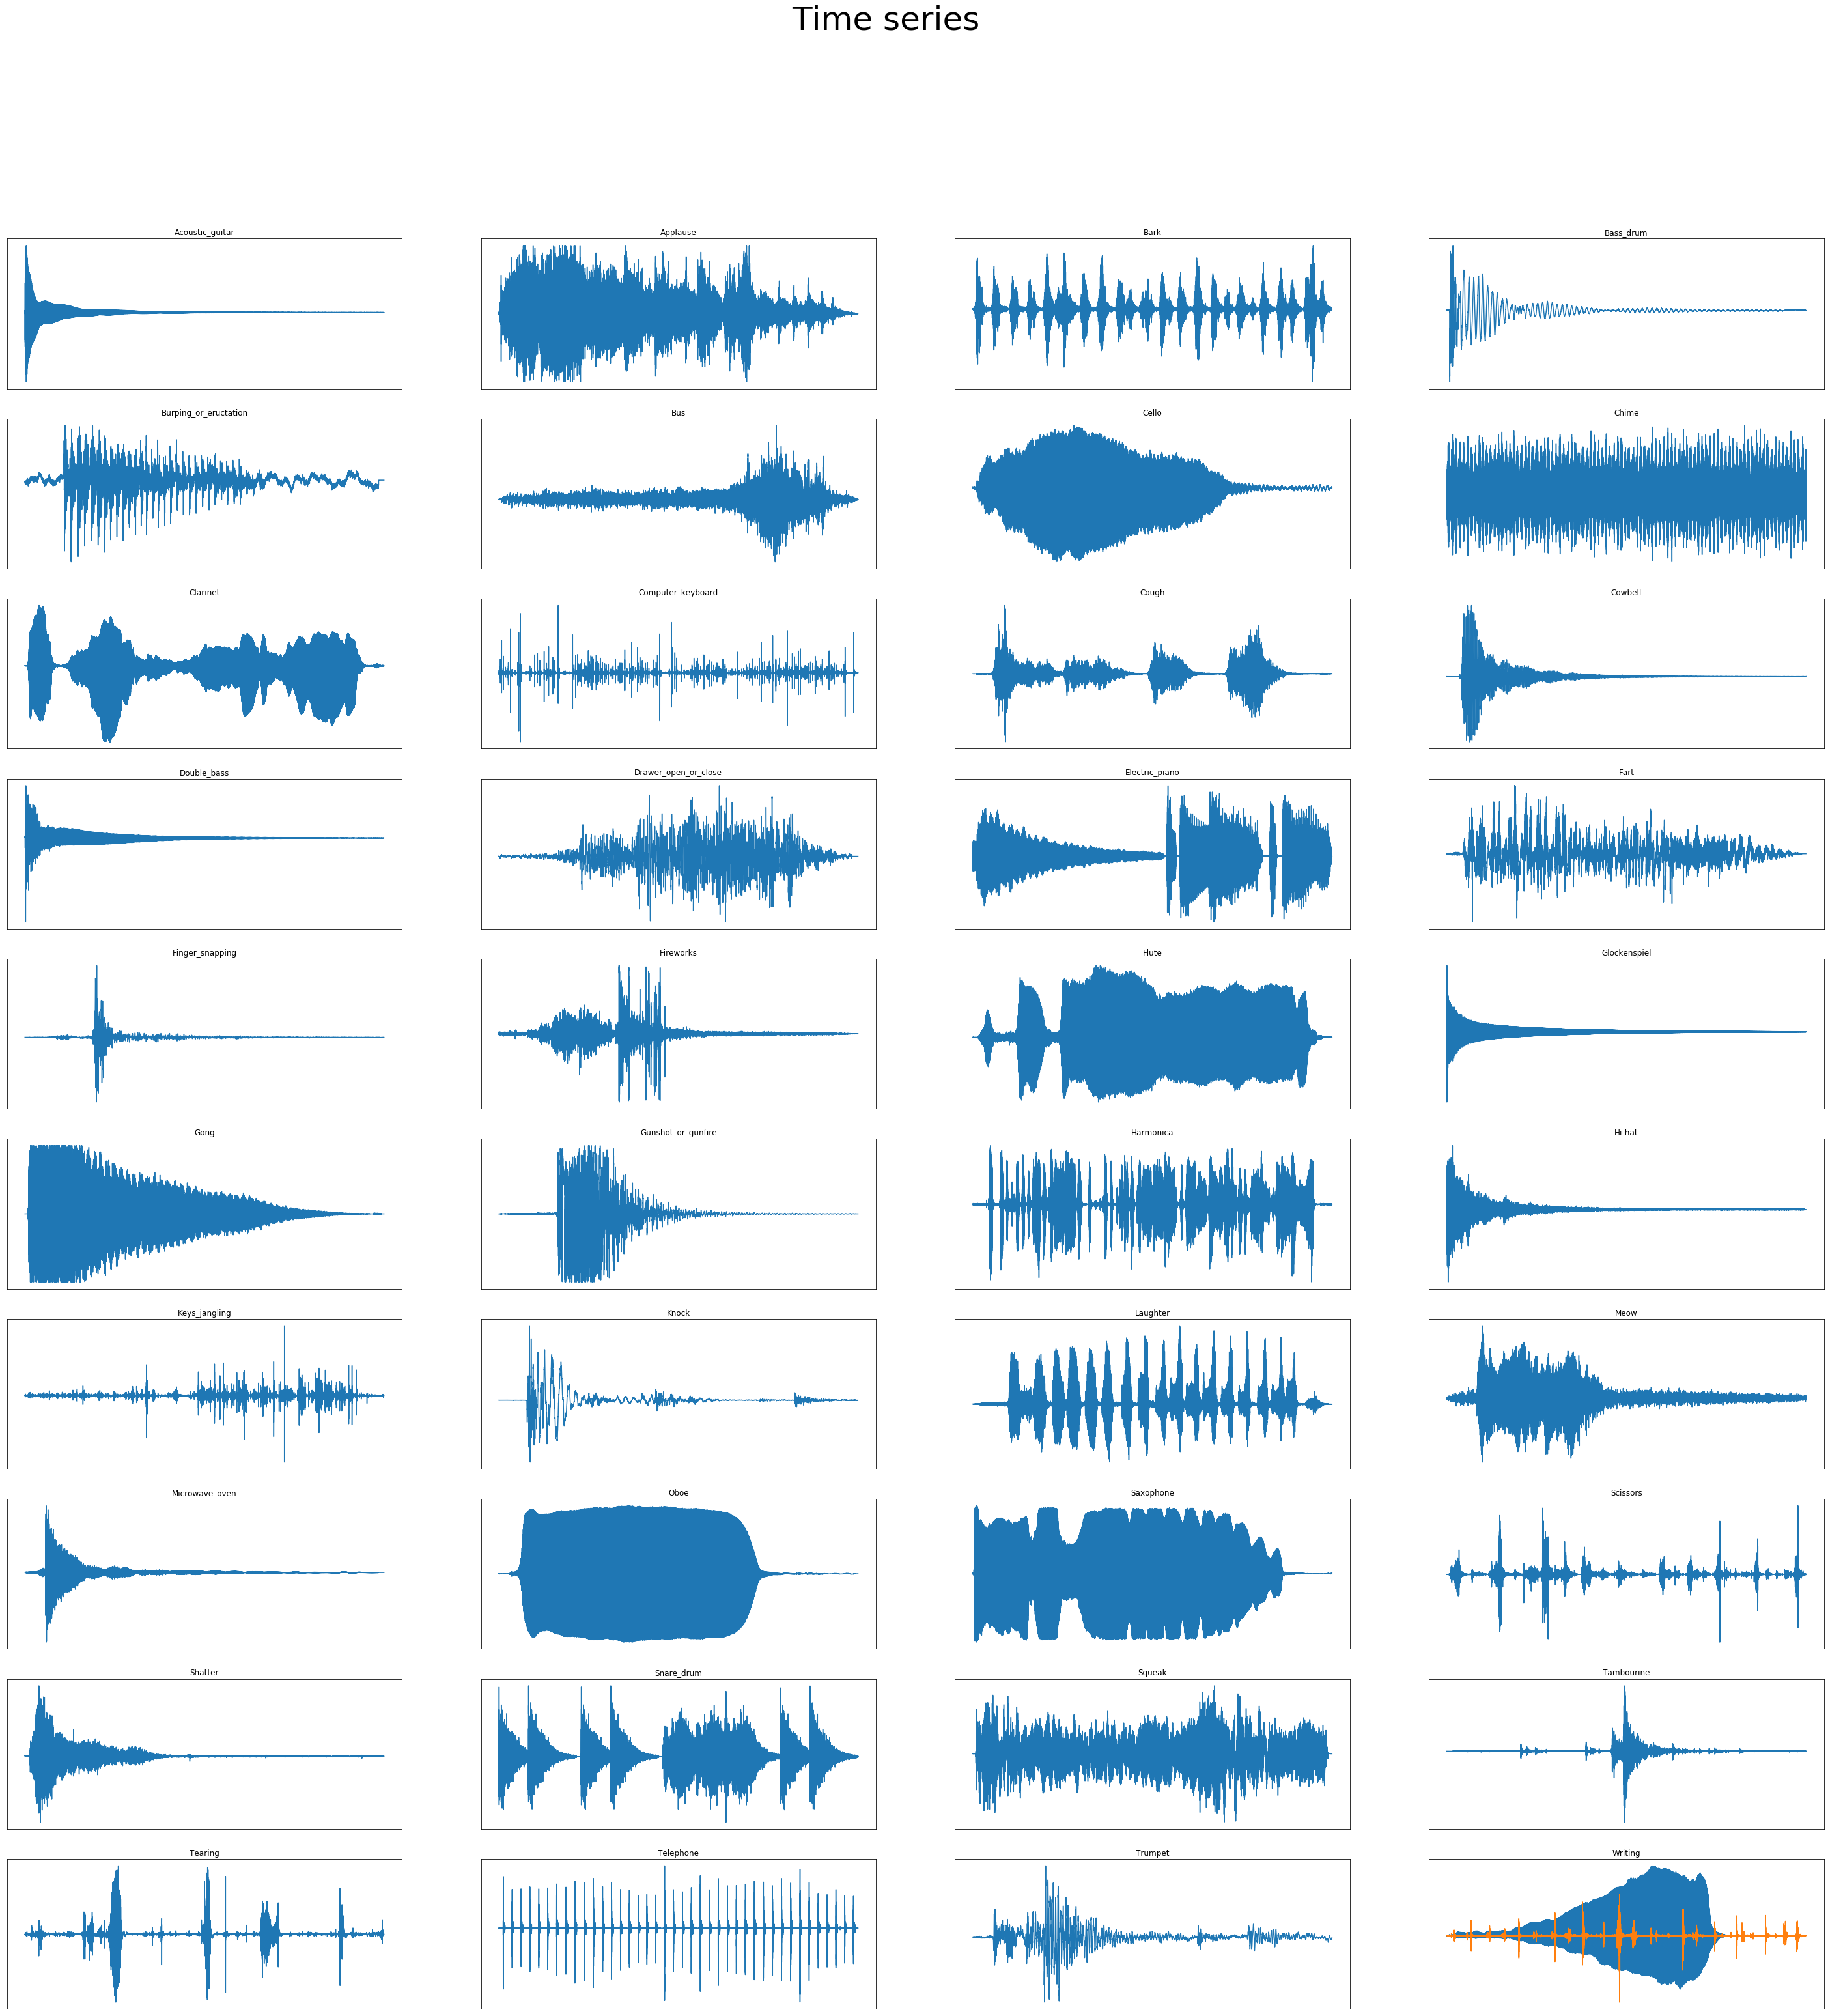

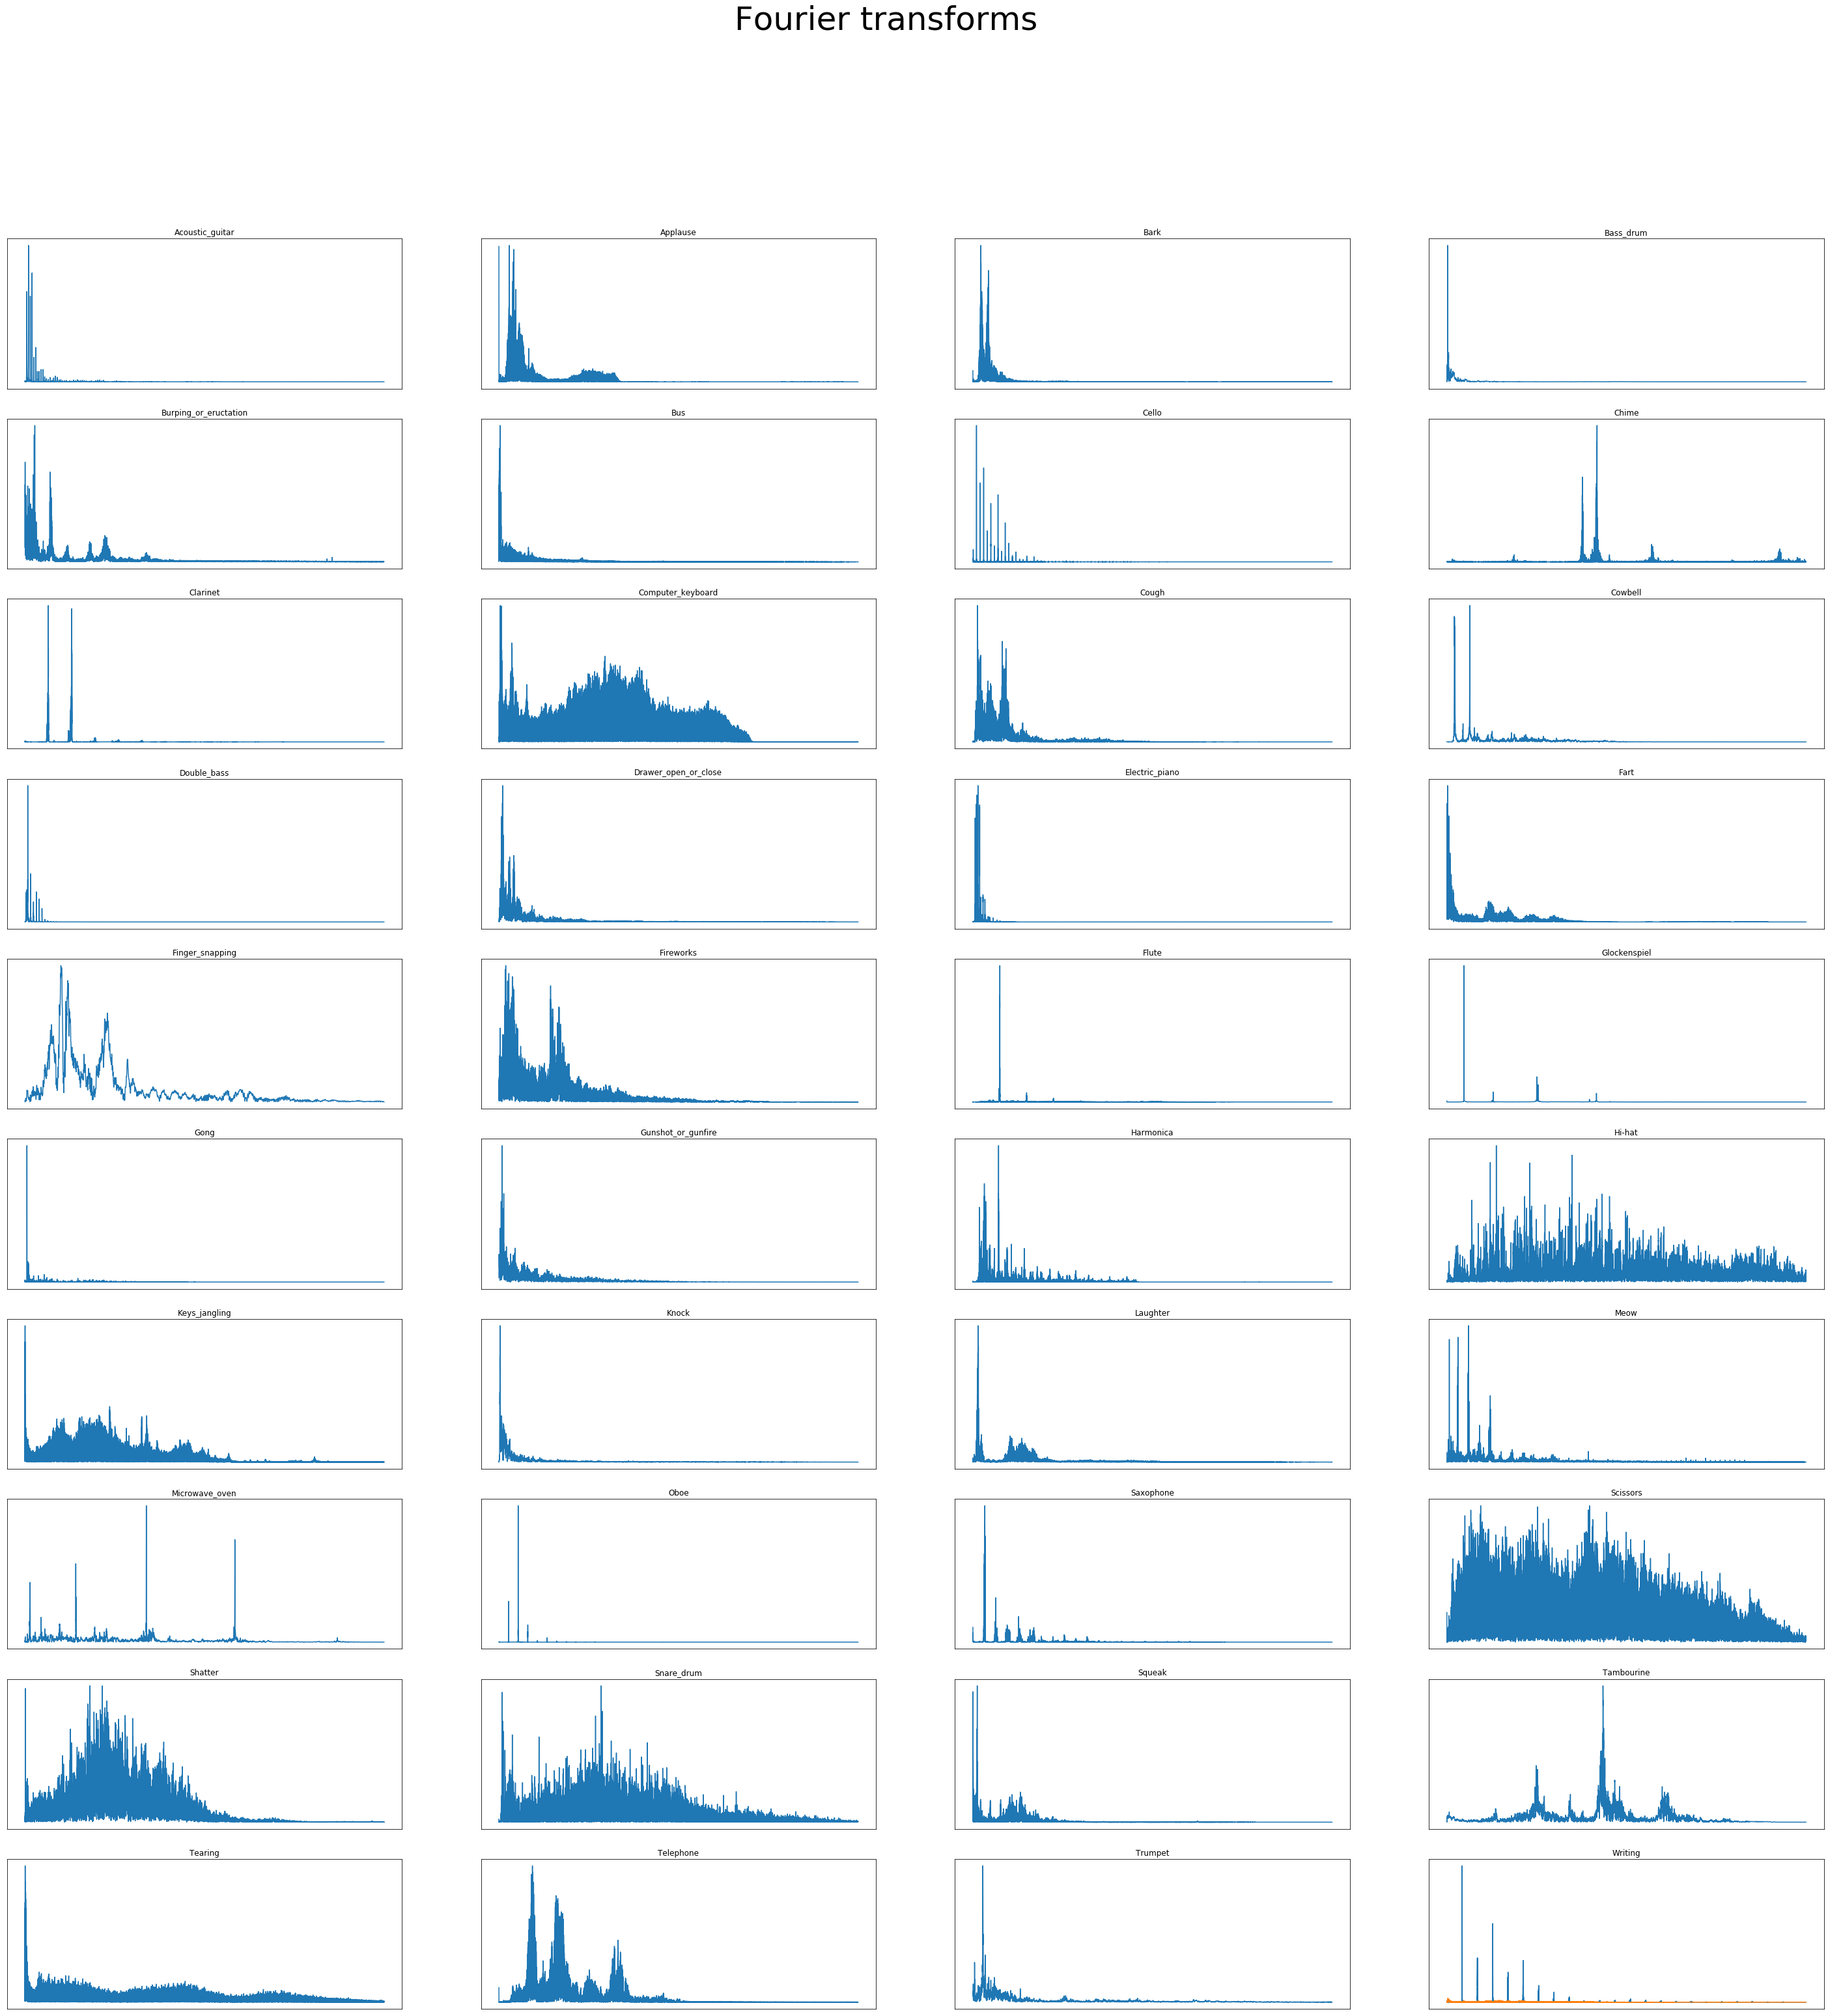

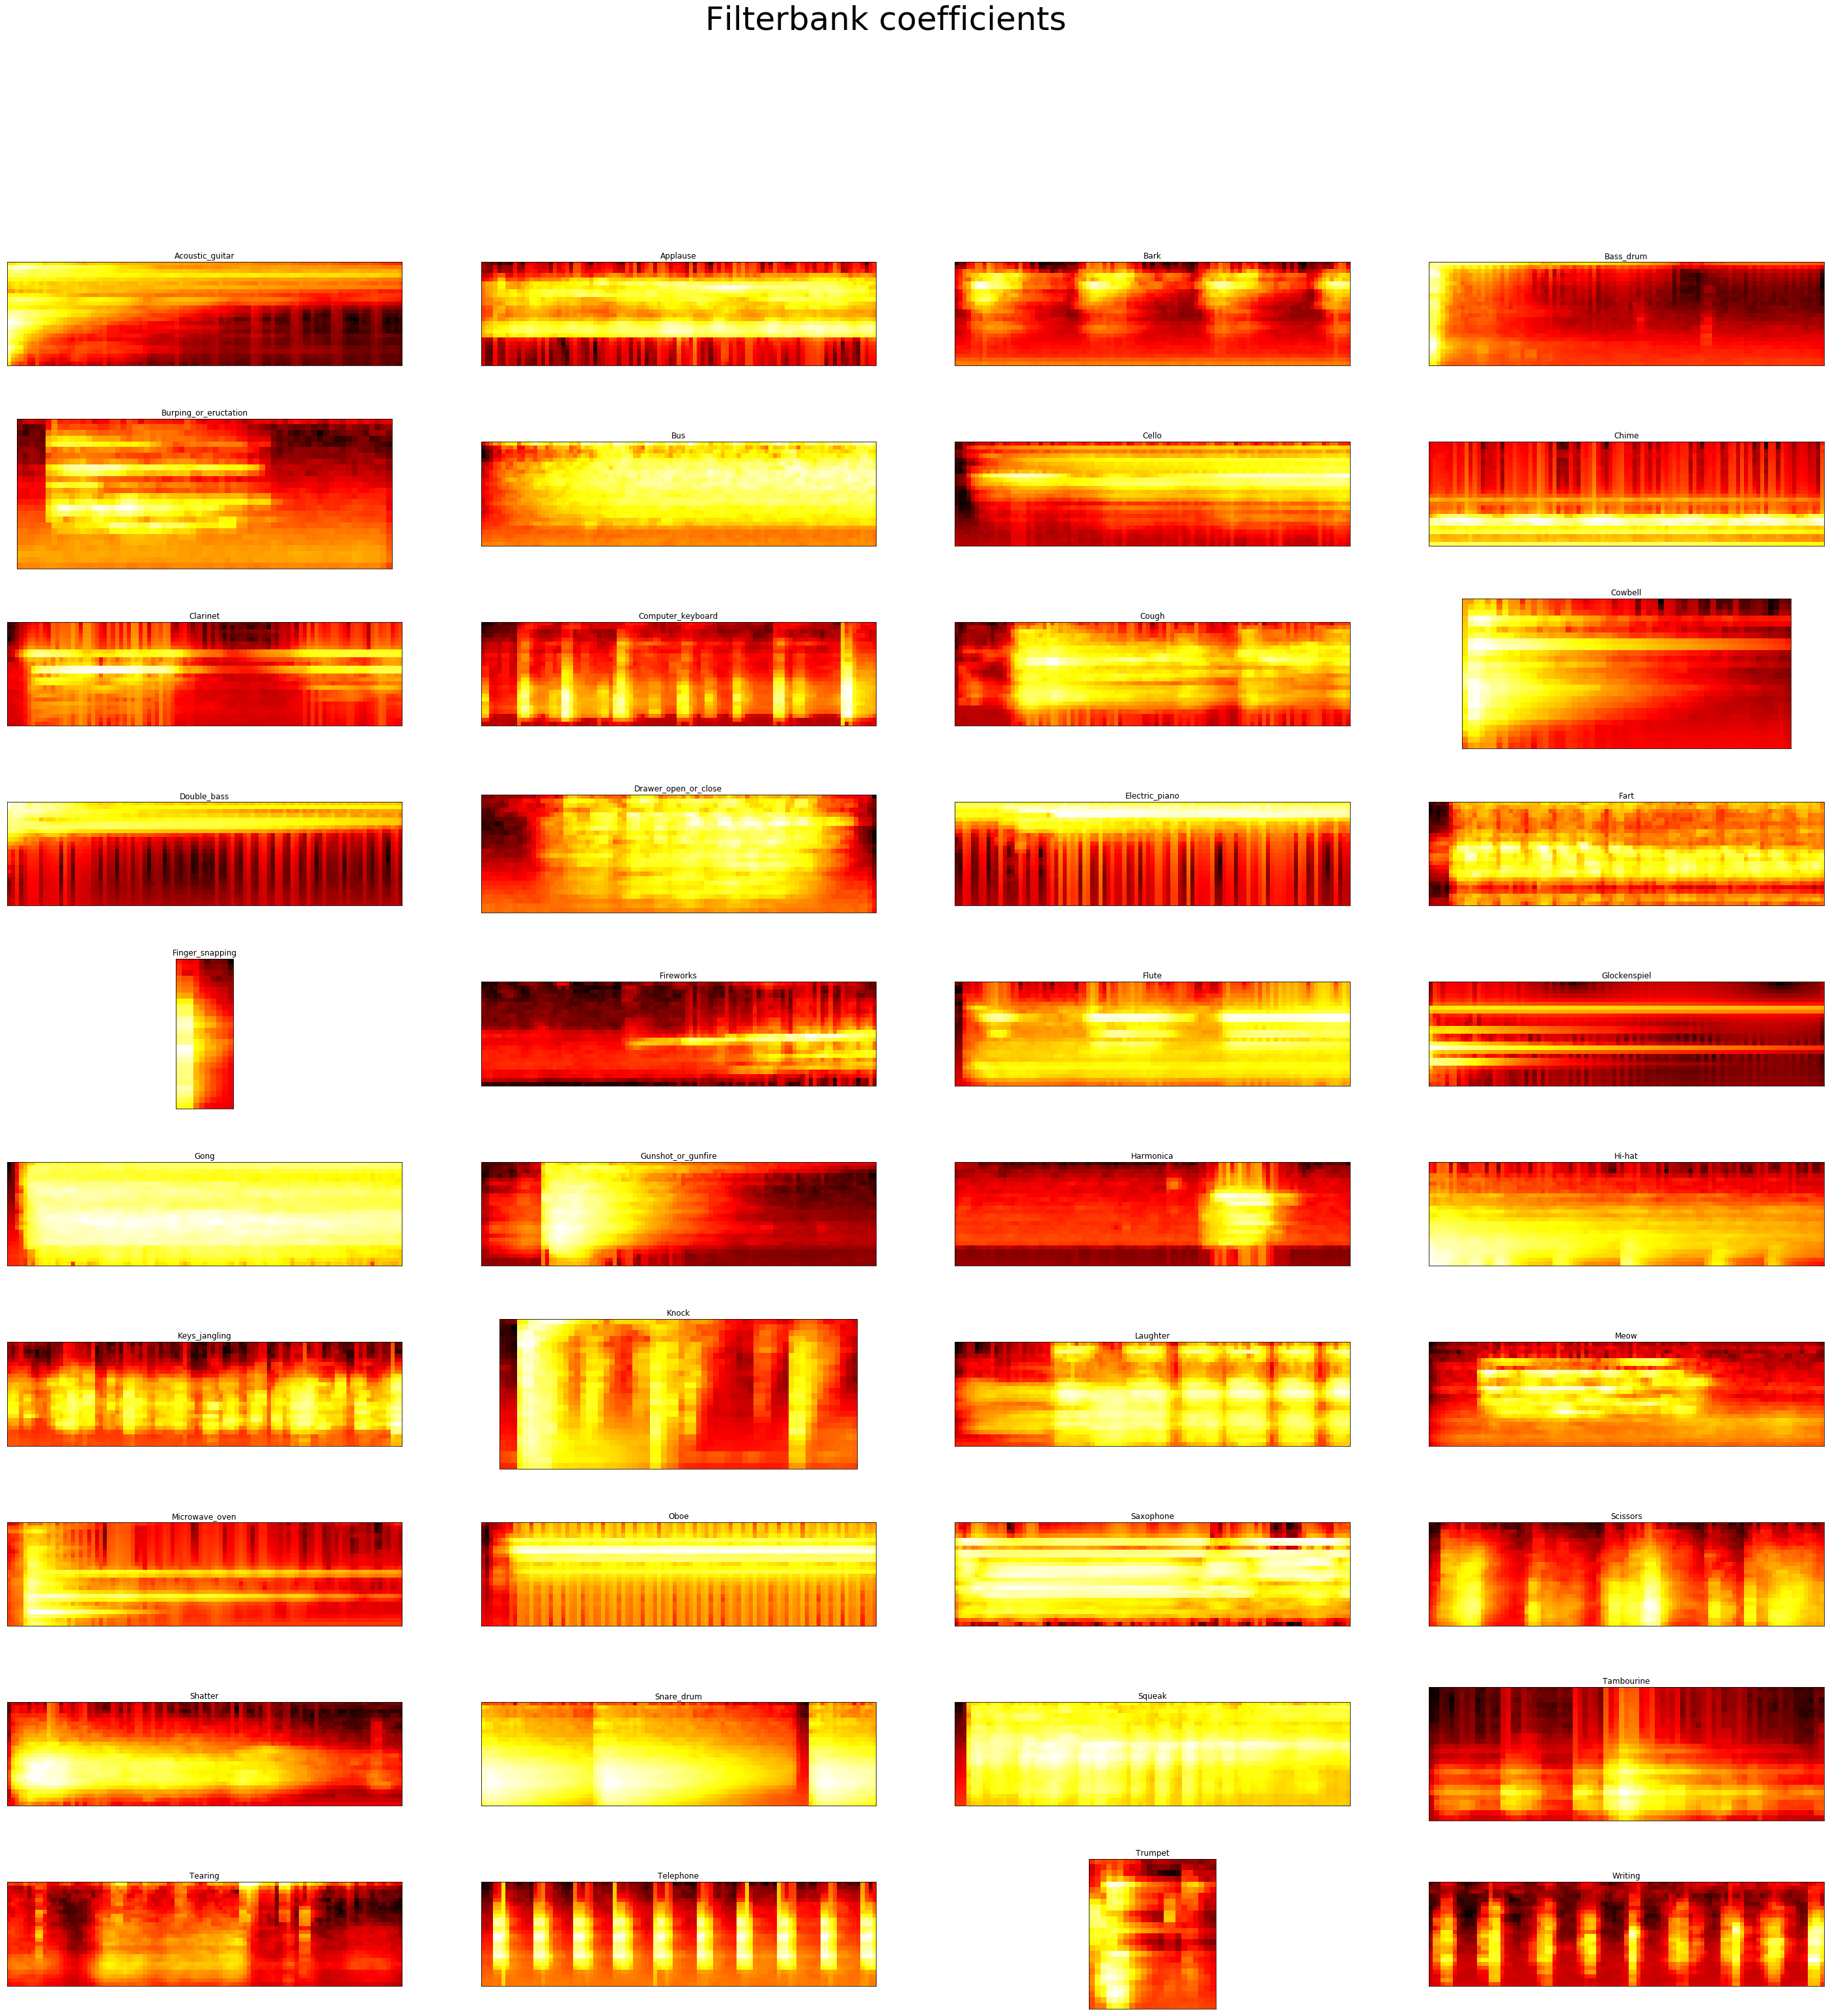

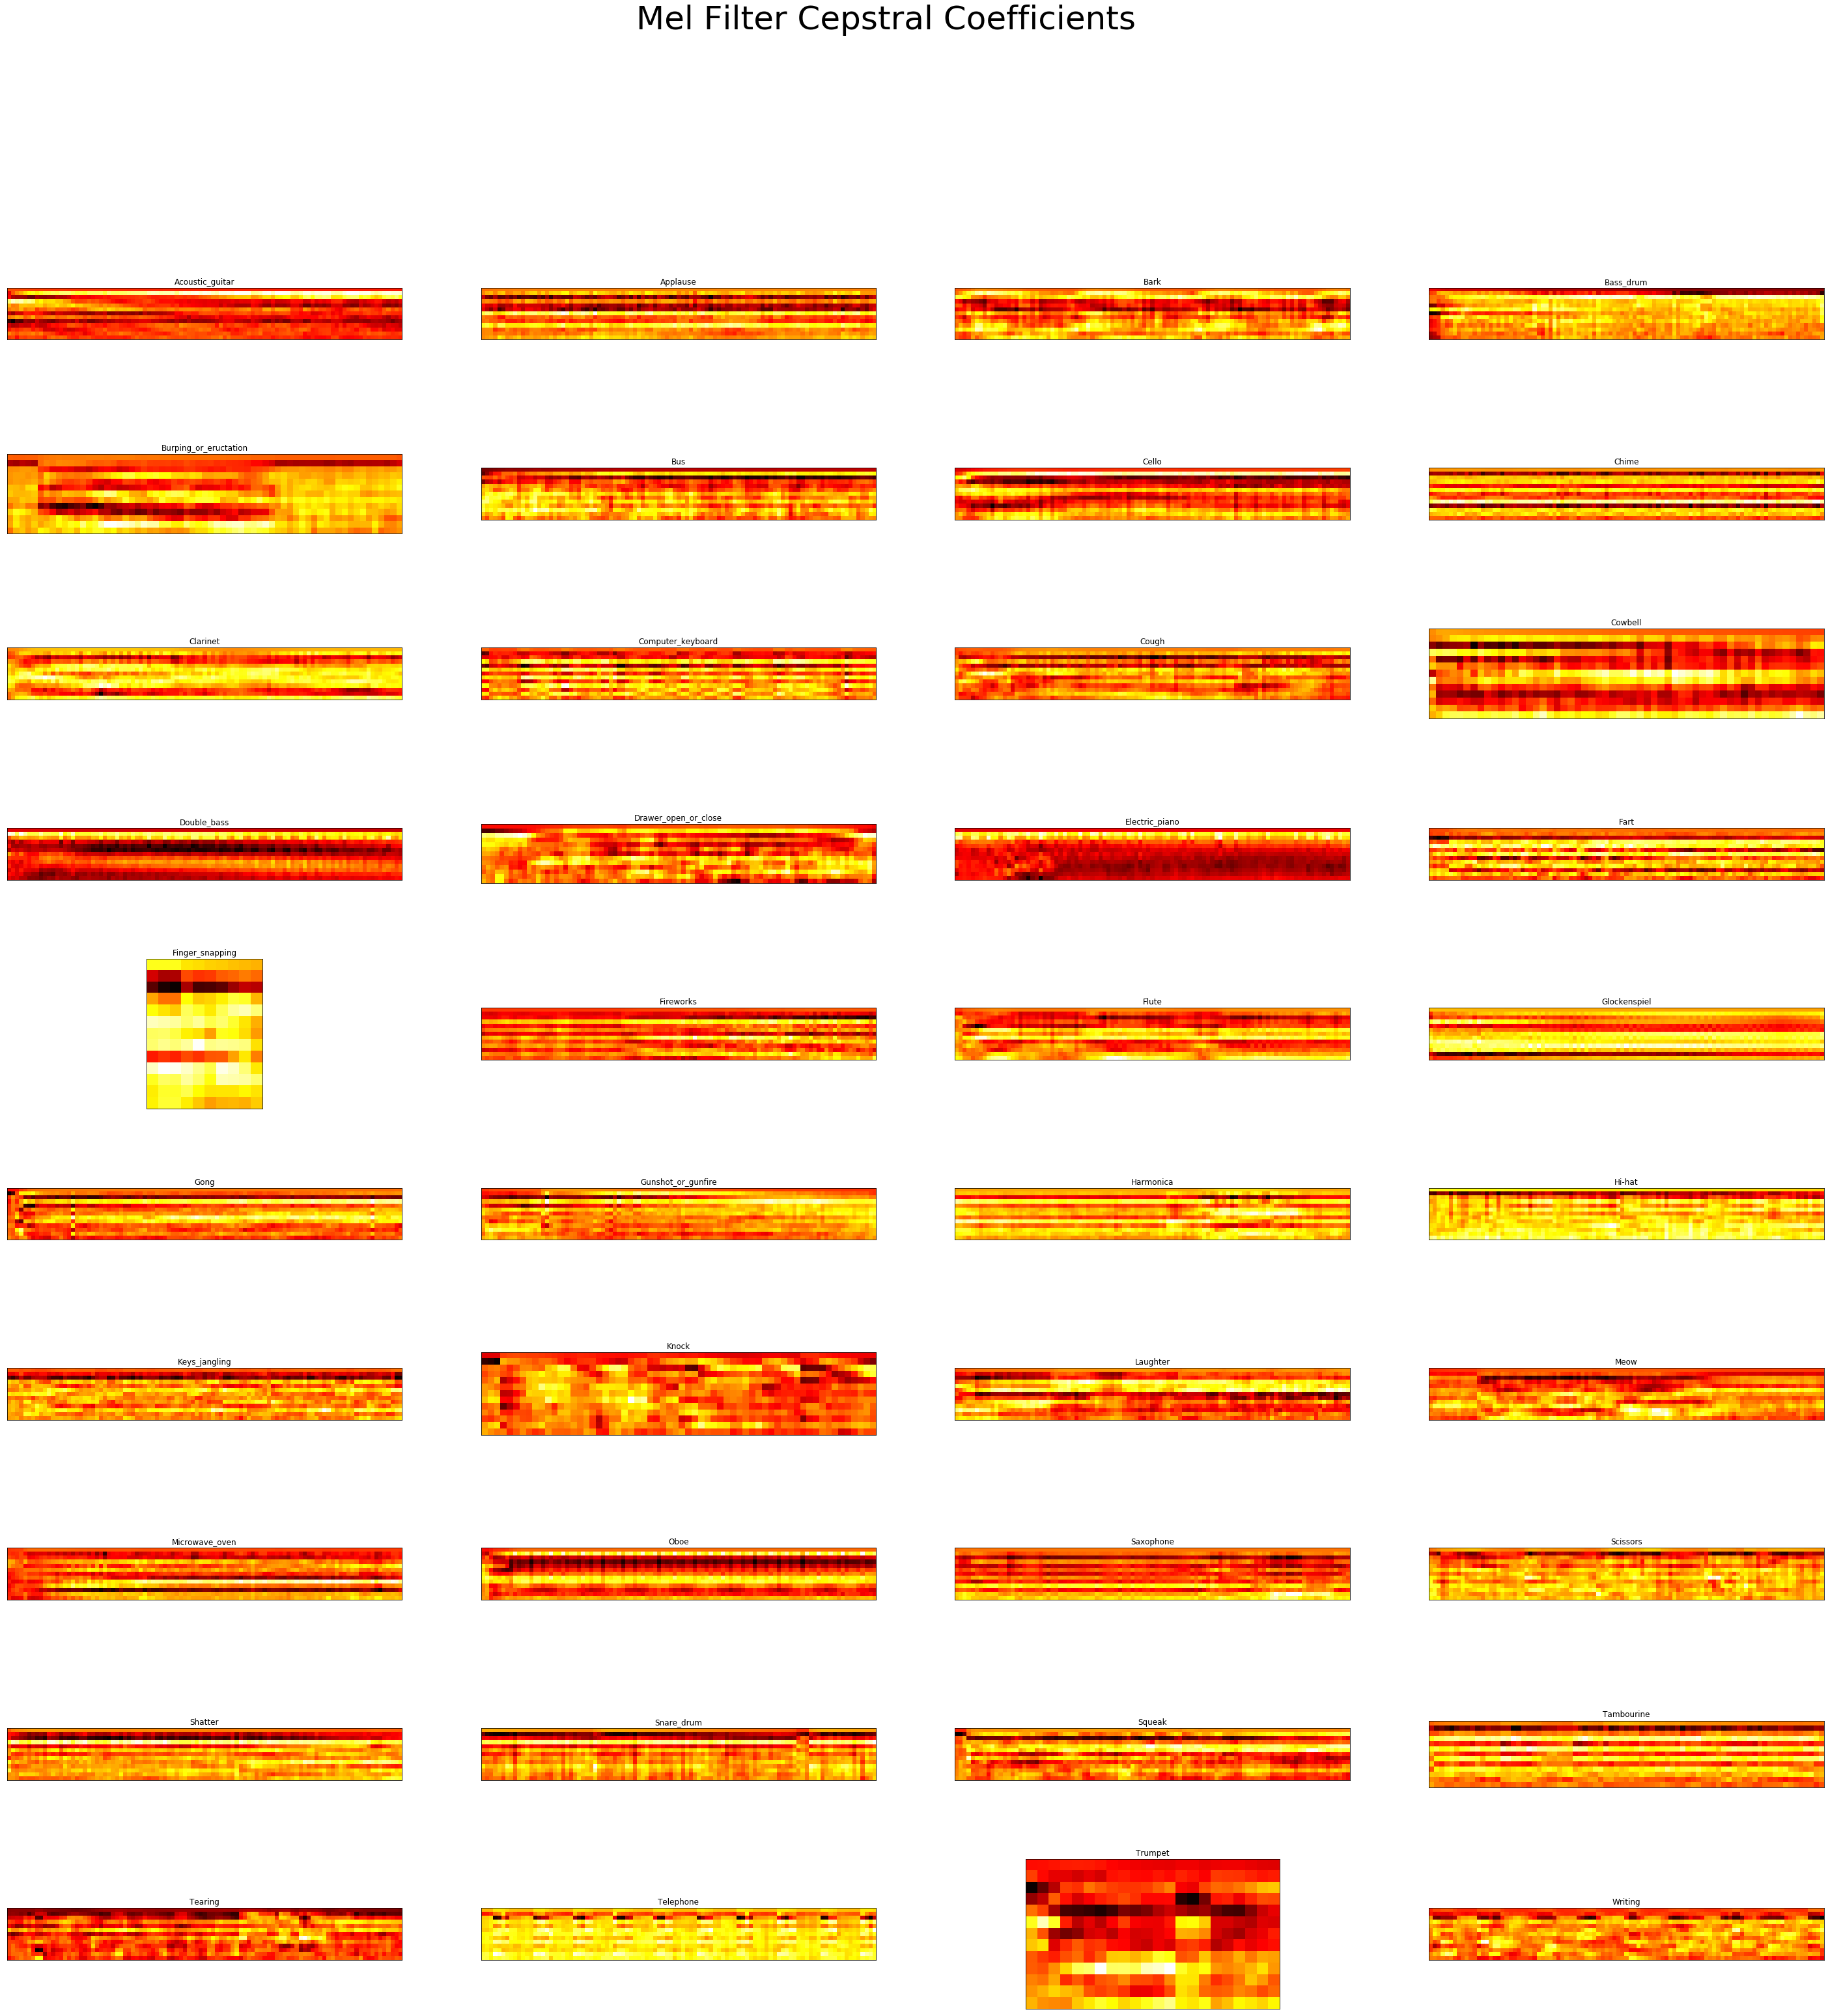

In [10]:
for c in classes:
    wav_file=df[df.label==c].iloc[0,0]
    length=df[df.label==c].iloc[0,2]
    signal,rate=librosa.load('C:\Audio-Classification-master\wavfiles/'+wav_file,sr=44100)#location of the audio files folder
    #print(rate,pd.Series(signal))
    #rate,signal=wavfile.read('C:\Audio-Classification-master\wavfiles/'+wav_file)
    #print(rate,pd.Series(signal))
    mask=envelope(signal,rate,0.0005)
    #print(len(signal),len(mask))
    signal=signal[mask]
    #print(len(signal))
    signal_dict[c]=signal
    fft_dict[c]=calc_fft(signal,rate)
    
    bank=logfbank(signal[:rate],rate,nfft=1103).T
    fbank_dict[c]=bank
    
    mel=mfcc(signal[:rate],rate,nfft=1103).T
    print('mfcc',mel.shape)
    mfcc_dict[c]=mel

plot_signals(signal_dict)
plt.show()

plot_fft(fft_dict)
plt.show()

plot_fbank(fbank_dict)
plt.show()

plot_mfcc(mfcc_dict)
plt.show()



In [14]:
if len(os.listdir('C:\Audio-Classification-master\clean_all'))==0:#location of folder where the preprocessed files are to be stored
    k=1
    for f in tqdm(df.fname):
        sig,rate=librosa.load('C:\Audio-Classification-master\wavfiles/'+f,sr=16000)
        mask=envelope(sig,rate,0.0005)
        #wavfile.write('C:\Audio-Classification-master\cleanDum/'+(df[df.fname==f].iloc[0,1])+str(k)+'.wav',rate=rate,data=sig[mask])
        wavfile.write('C:\Audio-Classification-master\clean_all/'+f,rate=rate,data=sig[mask])
        k+=1

100%|████████████████████████████████████████████████████████████████████████████| 9773/9773 [1:05:53<00:00,  2.47it/s]
